In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from joblib import dump as jdump
import time
import random

2021-10-10 00:03:25.233713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-10 00:03:25.233741: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
PATH2PROJECT = ""
SUBJECT_NUM = 1
CHOSEN_INPUTS = [0, 1, 2, 6, 7, 8, 9]
R_TRAIN = 0.9
N_EPOCHS = 200
PATIENCE = 16
N_SUBJECTS = 5
MIN_BRIGHTNESS_RATIO = 0.7
MAX_BRIGHTNESS_RATIO = 1.4
N_MODELS = 6
TRAINABLE_LAYERS = 2

In [3]:
x1_load = []
x2_load = []
y_load = []
dataset_dir = PATH2PROJECT + "Dataset/
datasets_folders = os.listdir(dataset_dir)

for data_fol in datasets_folders:
    with open(dataset_dir + f"{data_fol}/x1.pickle", "rb") as f:
        x1_load0 = pickle.load(f)
    with open(dataset_dir + f"{data_fol}/x2.pickle", "rb") as f:
        x2_load0 = pickle.load(f)
    with open(dataset_dir + f"{data_fol}/y.pickle", "rb") as f:
        y_load0 = pickle.load(f)
    for (x10, x20, y10) in zip(x1_load0, x2_load0, y_load0):
        x1_load.append(x10)
        x2_load.append(x20)
        y_load.append(y10)

x1_load = np.array(x1_load)
x2_load = np.array(x2_load)
y_load = np.array(y_load)

n_samples, frame_height, frame_width = x1_load.shape[:-1]
print(n_samples, frame_height, frame_width)

24500 48 44


In [4]:
x1_chg_bri = x1_load.copy()
for (i, _) in enumerate(x1_chg_bri):
    r = random.uniform(MIN_BRIGHTNESS_RATIO, MAX_BRIGHTNESS_RATIO)
    x1_chg_bri[i] = (x1_chg_bri[i] * r).astype(np.uint8)

In [5]:
x2_chs_inp = x2_load[:, CHOSEN_INPUTS]

[-2.92097984  0.01450496 -0.1692337   0.51821423  0.47875661  0.51987594
  0.49142322]
[2995.  948.]


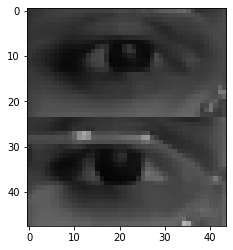

In [6]:
SAMPLE_NUMBER = 2
print(x2_chs_inp[SAMPLE_NUMBER])
print(y_load[SAMPLE_NUMBER])
plt.imshow(x1_chg_bri[SAMPLE_NUMBER].reshape((frame_height, frame_width)),
           cmap="gray", vmin=0, vmax=255)
plt.show()

In [7]:
x1_scaler = 255
x1 = x1_chg_bri / x1_scaler

x2_scaler = StandardScaler()
x2 = x2_scaler.fit_transform(x2_chs_inp)

y_scalers = y_load.max(0)
y = y_load / y_scalers

scalers = [x1_scaler, x2_scaler, y_scalers]
jdump(scalers, PATH2PROJECT + "Model/Models/trained/scalers.bin")

['Model/test/scalers.bin']

In [8]:
y1, y2 = y[:, 0], y[:, 1]

In [9]:
x1_shf, x2_shf, y1_shf, y2_shf = shuffle(x1, x2, y1, y2)

n_train = int(R_TRAIN * n_samples)
n_test = n_samples - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
y1_train, y2_train = y1_shf[:n_train], y2_shf[:n_train]
y1_test, y2_test = y1_shf[n_train:], y2_shf[n_train:]

print(x1_train.shape, x1_test.shape, y1_train.shape, y1_test.shape,
      x2_train.shape, x2_test.shape, y2_train.shape, y2_test.shape)

(22050, 48, 44, 1) (2450, 48, 44, 1) (22050,) (2450,) (22050, 7) (2450, 7) (22050,) (2450,)


In [10]:
x_train_list = [x1_train, x2_train]
x_test_list = [x1_test, x2_test]
y_train_list = [y1_train, y2_train]
y_test_list = [y1_test, y2_test]

In [11]:
subjects_dir = PATH2PROJECT + "Subjects/"

with open(subjects_dir + f"{SUBJECT_NUM}/x1.pickle", "rb") as f:
    x1_sbj_load = pickle.load(f)
with open(subjects_dir + f"{SUBJECT_NUM}/x2.pickle", "rb") as f:
    x2_sbj_load = pickle.load(f)
with open(subjects_dir + f"{SUBJECT_NUM}/y.pickle", "rb") as f:
    y_sbj_load = pickle.load(f)

n_smp_sbj = x1_sbj_load.shape[0]
print(n_smp_sbj)

14000


In [12]:
x2_sbj_chs_inp = x2_sbj_load[:, CHOSEN_INPUTS]

In [13]:
x1_sbj = x1_sbj_load / x1_scaler
x2_sbj = x2_scaler.transform(x2_sbj_chs_inp)
y_sbj = y_sbj_load / y_scalers

In [14]:
points3x3 = np.array([1, 3, 5, 10, 17, 18, 20, 26, 31])
n_smp_slc = 100
n_smp_pnt = 400

n_point = n_smp_sbj // n_smp_pnt
x1_seen = []
x2_seen = []
y_seen = []
x1_unseen = []
x2_unseen = []
y_unseen = []

for i in range(n_point):
    if np.sum(i == points3x3) == 1:
        for j in range(n_smp_slc):
            x1_seen.append(x1_sbj[i * n_smp_pnt + j])
            x2_seen.append(x2_sbj[i * n_smp_pnt + j])
            y_seen.append(y_sbj[i * n_smp_pnt + j])
    else:
        for j in range(n_smp_pnt):
            x1_unseen.append(x1_sbj[i * n_smp_pnt + j])
            x2_unseen.append(x2_sbj[i * n_smp_pnt + j])
            y_unseen.append(y_sbj[i * n_smp_pnt + j])

x1_seen = np.array(x1_seen)
x2_seen = np.array(x2_seen)
y_seen = np.array(y_seen)
x1_unseen = np.array(x1_unseen)
x2_unseen = np.array(x2_unseen)
y_unseen = np.array(y_unseen)

n_seen = x1_seen.shape[0]
n_unseen = x1_unseen.shape[0]
print(n_seen)
print(n_unseen)

900
10400


[ 0.55829163  0.35274728 -0.18863474 -0.71921379 -0.63960778  0.4223304
  0.19969227]
[0.5 0. ]


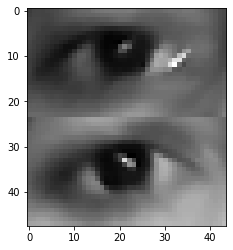

In [15]:
SAMPLE_NUMBER = 120
print(x2_seen[SAMPLE_NUMBER])
print(y_seen[SAMPLE_NUMBER])
plt.imshow(x1_seen[SAMPLE_NUMBER].
           reshape((frame_height, frame_width)), cmap="gray")
plt.show()

In [16]:
y1_seen, y2_seen = y_seen[:, 0], y_seen[:, 1]
y1_unseen, y2_unseen = y_unseen[:, 0], y_unseen[:, 1]

In [17]:
(
  x1_seen_shf,
  x2_seen_shf,
  y1_seen_shf,
  y2_seen_shf
) = shuffle(
    x1_seen,
    x2_seen,
    y1_seen,
    y2_seen
    )

n_train_seen = int(R_TRAIN * n_seen)
n_test_seen = n_seen - n_train_seen
x1_train_seen = x1_seen_shf[:n_train_seen]
x2_train_seen = x2_seen_shf[:n_train_seen]
x1_test_seen = x1_seen_shf[n_train_seen:]
x2_test_seen = x2_seen_shf[n_train_seen:]
y1_train_seen = y1_seen_shf[:n_train_seen]
y2_train_seen = y2_seen_shf[:n_train_seen]
y1_test_seen = y1_seen_shf[n_train_seen:]
y2_test_seen = y2_seen_shf[n_train_seen:]

(
    x1_unseen_shf,
    x2_unseen_shf,
    y1_unseen_shf,
    y2_unseen_shf
) = shuffle(
    x1_unseen,
    x2_unseen,
    y1_unseen,
    y2_unseen
)

print(x1_train_seen.shape, x1_test_seen.shape,
      y1_train_seen.shape, y1_test_seen.shape,
      x2_train_seen.shape, x2_test_seen.shape,
      y2_train_seen.shape, y2_test_seen.shape,
      x1_unseen_shf.shape, x2_unseen_shf.shape,
      y1_unseen_shf.shape, y2_unseen_shf.shape)

(810, 48, 44, 1) (90, 48, 44, 1) (810,) (90,) (810, 7) (90, 7) (810,) (90,) (10400, 48, 44, 1) (10400, 7) (10400,) (10400,)


In [18]:
x_train_seen_list = [x1_train_seen, x2_train_seen]
x_test_seen_list = [x1_test_seen, x2_test_seen]
y_train_seen_list = [y1_train_seen, y2_train_seen]
y_test_seen_list = [y1_test_seen, y2_test_seen]

x_unseen_list = [x1_unseen_shf, x2_unseen_shf]
y_unseen_list = [y1_unseen_shf, y2_unseen_shf]

In [19]:
cb = EarlyStopping(patience=PATIENCE, verbose=1, restore_best_weights=True)

In [21]:
raw_models_dir = PATH2PROJECT + "Model/Models/raw/"
trained_models_dir = PATH2PROJECT + "Model/Models/trained1/"
raw_models_folders = os.listdir(raw_models_dir)

t1 = time.time()
losses = []
for model_fol in raw_models_folders:
    model = load_model(raw_models_dir + model_fol)
    print(f"*********** {model_fol} ************")
    model.fit(x_train_list,
              y_train_list,
              validation_data=(x_test_list, y_test_list),
              epochs=N_EPOCHS,
              callbacks=cb)

    yhat_train_list = model.predict(x_train_list)
    yhat_test_list = model.predict(x_test_list)
    
    y_train = np.concatenate((np.expand_dims(y_train_list[0], 1), np.expand_dims(y_train_list[1], 1)), 1)
    yhat_train = np.concatenate((yhat_train_list[0], yhat_train_list[1]), 1)
    y_test = np.concatenate((np.expand_dims(y_test_list[0], 1), np.expand_dims(y_test_list[1], 1)), 1)
    yhat_test = np.concatenate((yhat_test_list[0], yhat_test_list[1]), 1)

    train_loss = np.abs(y_train - yhat_train).sum(0) / n_train
    test_loss = np.abs(y_test - yhat_test).sum(0) / n_test

    for layer in model.layers[:-TRAINABLE_LAYERS]:
        layer.trainable = False
    for layer in model.layers:
        print(layer, layer.trainable)
  
    model.fit(x_train_seen_list,
              y_train_seen_list,
              validation_data=(x_test_seen_list, y_test_seen_list),
              epochs=N_EPOCHS,
              callbacks=cb)
    
    yhat_train_seen_list = model.predict(x_train_seen_list)
    yhat_test_seen_list = model.predict(x_test_seen_list)
    yhat_unseen_list = model.predict(x_unseen_list)
    
    y_train_seen = np.concatenate((np.expand_dims(y_train_seen_list[0], 1),
                                   np.expand_dims(y_train_seen_list[1], 1)), 1)
    yhat_train_seen = np.concatenate((yhat_train_seen_list[0],
                                      yhat_train_seen_list[1]), 1)
    y_test_seen = np.concatenate((np.expand_dims(y_test_seen_list[0], 1),
                             np.expand_dims(y_test_seen_list[1], 1)), 1)
    yhat_test_seen = np.concatenate((yhat_test_seen_list[0],
                                     yhat_test_seen_list[1]), 1)
    y_unseen_new = np.concatenate((np.expand_dims(y_unseen_list[0], 1),
                                   np.expand_dims(y_unseen_list[1], 1)), 1)
    yhat_unseen = np.concatenate((yhat_unseen_list[0],
                                  yhat_unseen_list[1]), 1)
    
    train_seen_loss = np.abs(y_train_seen - yhat_train_seen).sum(0) / n_train_seen
    test_seen_loss = np.abs(y_test_seen - yhat_test_seen).sum(0) / n_test_seen
    unseen_loss = np.abs(y_unseen - yhat_unseen).sum(0) / n_unseen
    
    loss = [train_loss, test_loss, train_seen_loss, test_seen_loss, unseen_loss]
    losses.append(loss)
    
    model.save(trained_models_dir + model_fol")
    print(loss)

jdump(losses, trained_models_dir)
elapsed_time = (time.time() - t1) / 60
print("Training Fineshed!")
print(elapsed_time)

*********** Model 1 ************


2021-10-10 00:03:32.697921: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 186278400 exceeds 10% of free system memory.
2021-10-10 00:03:32.827945: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
690/690 [==============================] - 17s 23ms/step - loss: 0.4387 - dense_20_loss: 0.1958 - dense_21_loss: 0.2429 - val_loss: 0.3271 - val_dense_20_loss: 0.1314 - val_dense_21_loss: 0.1957
Epoch 2/200
690/690 [==============================] - 17s 24ms/step - loss: 0.3123 - dense_20_loss: 0.1324 - dense_21_loss: 0.1799 - val_loss: 0.2858 - val_dense_20_loss: 0.1146 - val_dense_21_loss: 0.1711
Epoch 3/200
690/690 [==============================] - 17s 24ms/step - loss: 0.2716 - dense_20_loss: 0.1148 - dense_21_loss: 0.1567 - val_loss: 0.2717 - val_dense_20_loss: 0.1077 - val_dense_21_loss: 0.1640
Epoch 4/200
690/690 [==============================] - 17s 24ms/step - loss: 0.2494 - dense_20_loss: 0.1054 - dense_21_loss: 0.1440 - val_loss: 0.2444 - val_dense_20_loss: 0.1030 - val_dense_21_loss: 0.1415
Epoch 5/200
690/690 [==============================] - 17s 24ms/step - loss: 0.2368 - dense_20_loss: 0.1002 - dense_21_loss: 0.1365 - val_loss: 0.2989 - val_dense_20_loss: 

690/690 [==============================] - 17s 24ms/step - loss: 0.1724 - dense_20_loss: 0.0744 - dense_21_loss: 0.0980 - val_loss: 0.2070 - val_dense_20_loss: 0.0861 - val_dense_21_loss: 0.1209
Epoch 80/200
690/690 [==============================] - 17s 24ms/step - loss: 0.1711 - dense_20_loss: 0.0731 - dense_21_loss: 0.0980 - val_loss: 0.2162 - val_dense_20_loss: 0.0838 - val_dense_21_loss: 0.1324
Epoch 81/200
690/690 [==============================] - 17s 25ms/step - loss: 0.1752 - dense_20_loss: 0.0742 - dense_21_loss: 0.1009 - val_loss: 0.2183 - val_dense_20_loss: 0.0867 - val_dense_21_loss: 0.1316
Epoch 82/200
690/690 [==============================] - 17s 24ms/step - loss: 0.1740 - dense_20_loss: 0.0740 - dense_21_loss: 0.1000 - val_loss: 0.1966 - val_dense_20_loss: 0.0773 - val_dense_21_loss: 0.1193
Epoch 83/200
690/690 [==============================] - 16s 23ms/step - loss: 0.1668 - dense_20_loss: 0.0717 - dense_21_loss: 0.0952 - val_loss: 0.1874 - val_dense_20_loss: 0.0819 -

2021-10-10 00:27:43.644104: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 186278400 exceeds 10% of free system memory.


<keras.engine.input_layer.InputLayer object at 0x7fef36552eb0> False
<keras.layers.convolutional.Conv2D object at 0x7fef367ad640> False
<keras.layers.core.Dropout object at 0x7fef367adbe0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fef366c10d0> False
<keras.layers.convolutional.Conv2D object at 0x7fef366c13d0> False
<keras.layers.core.Dropout object at 0x7fef366c1c10> False
<keras.layers.pooling.MaxPooling2D object at 0x7fef366c14f0> False
<keras.layers.convolutional.Conv2D object at 0x7fef366d6130> False
<keras.layers.core.Dropout object at 0x7fef366d6970> False
<keras.layers.pooling.MaxPooling2D object at 0x7fef366d6250> False
<keras.layers.core.Flatten object at 0x7fef366d6c40> False
<keras.layers.core.Dense object at 0x7fef3665c100> False
<keras.layers.core.Dropout object at 0x7fef3665c7c0> False
<keras.engine.input_layer.InputLayer object at 0x7fef3665c7f0> False
<keras.layers.merge.Concatenate object at 0x7fef3665cdc0> False
<keras.layers.core.Dense object at 0x7fef366

Epoch 32/200
26/26 [==============================] - 1s 23ms/step - loss: 0.0906 - dense_20_loss: 0.0346 - dense_21_loss: 0.0560 - val_loss: 0.1423 - val_dense_20_loss: 0.0355 - val_dense_21_loss: 0.1068
Epoch 33/200
26/26 [==============================] - 1s 23ms/step - loss: 0.0932 - dense_20_loss: 0.0352 - dense_21_loss: 0.0580 - val_loss: 0.1396 - val_dense_20_loss: 0.0335 - val_dense_21_loss: 0.1061
Epoch 34/200
26/26 [==============================] - 1s 23ms/step - loss: 0.0946 - dense_20_loss: 0.0375 - dense_21_loss: 0.0571 - val_loss: 0.1293 - val_dense_20_loss: 0.0404 - val_dense_21_loss: 0.0889
Epoch 35/200
26/26 [==============================] - 1s 23ms/step - loss: 0.0928 - dense_20_loss: 0.0335 - dense_21_loss: 0.0593 - val_loss: 0.1190 - val_dense_20_loss: 0.0294 - val_dense_21_loss: 0.0896
Epoch 36/200
26/26 [==============================] - 1s 23ms/step - loss: 0.0925 - dense_20_loss: 0.0330 - dense_21_loss: 0.0595 - val_loss: 0.1195 - val_dense_20_loss: 0.0351 - v

Epoch 72/200
26/26 [==============================] - 1s 23ms/step - loss: 0.0632 - dense_20_loss: 0.0292 - dense_21_loss: 0.0340 - val_loss: 0.1089 - val_dense_20_loss: 0.0293 - val_dense_21_loss: 0.0796
Epoch 73/200
26/26 [==============================] - 1s 23ms/step - loss: 0.0555 - dense_20_loss: 0.0237 - dense_21_loss: 0.0318 - val_loss: 0.1029 - val_dense_20_loss: 0.0299 - val_dense_21_loss: 0.0729
Epoch 74/200
26/26 [==============================] - 1s 23ms/step - loss: 0.0573 - dense_20_loss: 0.0226 - dense_21_loss: 0.0347 - val_loss: 0.1218 - val_dense_20_loss: 0.0291 - val_dense_21_loss: 0.0927
Epoch 75/200
26/26 [==============================] - 1s 23ms/step - loss: 0.0608 - dense_20_loss: 0.0240 - dense_21_loss: 0.0368 - val_loss: 0.1188 - val_dense_20_loss: 0.0303 - val_dense_21_loss: 0.0885
Epoch 76/200
26/26 [==============================] - 1s 23ms/step - loss: 0.0689 - dense_20_loss: 0.0261 - dense_21_loss: 0.0428 - val_loss: 0.1186 - val_dense_20_loss: 0.0273 - v

2021-10-10 00:28:38.548353: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Model/trained/model1.model/assets
*********** Model 2 ************
Epoch 1/200


2021-10-10 00:28:39.985536: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 186278400 exceeds 10% of free system memory.


690/690 [==============================] - 28s 39ms/step - loss: 0.3981 - dense_31_loss: 0.1691 - dense_32_loss: 0.2290 - val_loss: 0.3210 - val_dense_31_loss: 0.1275 - val_dense_32_loss: 0.1934
Epoch 2/200
690/690 [==============================] - 27s 39ms/step - loss: 0.2699 - dense_31_loss: 0.1094 - dense_32_loss: 0.1605 - val_loss: 0.3084 - val_dense_31_loss: 0.1224 - val_dense_32_loss: 0.1860
Epoch 3/200
690/690 [==============================] - 27s 39ms/step - loss: 0.2364 - dense_31_loss: 0.0964 - dense_32_loss: 0.1400 - val_loss: 0.3446 - val_dense_31_loss: 0.1099 - val_dense_32_loss: 0.2347
Epoch 4/200
690/690 [==============================] - 27s 39ms/step - loss: 0.2212 - dense_31_loss: 0.0898 - dense_32_loss: 0.1314 - val_loss: 0.3206 - val_dense_31_loss: 0.1248 - val_dense_32_loss: 0.1957
Epoch 5/200
690/690 [==============================] - 27s 38ms/step - loss: 0.2097 - dense_31_loss: 0.0864 - dense_32_loss: 0.1233 - val_loss: 0.2609 - val_dense_31_loss: 0.1045 - val

2021-10-10 01:01:53.673802: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 186278400 exceeds 10% of free system memory.


<keras.engine.input_layer.InputLayer object at 0x7fef3651b0a0> False
<keras.layers.convolutional.Conv2D object at 0x7fef360b2f10> False
<keras.layers.core.Dropout object at 0x7fef360b8580> False
<keras.layers.pooling.MaxPooling2D object at 0x7fef360b85e0> False
<keras.layers.convolutional.Conv2D object at 0x7fef360b8610> False
<keras.layers.core.Dropout object at 0x7fef360b8fa0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fef360800d0> False
<keras.layers.convolutional.Conv2D object at 0x7fef360803d0> False
<keras.layers.core.Dropout object at 0x7fef36080c10> False
<keras.layers.pooling.MaxPooling2D object at 0x7fef360804f0> False
<keras.layers.core.Flatten object at 0x7fef36087160> False
<keras.layers.core.Dense object at 0x7fef36087370> False
<keras.layers.core.Dropout object at 0x7fef36087a60> False
<keras.engine.input_layer.InputLayer object at 0x7fef36087a90> False
<keras.layers.merge.Concatenate object at 0x7fef3608f070> False
<keras.layers.core.Dense object at 0x7fef360

Epoch 32/200
26/26 [==============================] - 1s 39ms/step - loss: 0.0961 - dense_31_loss: 0.0439 - dense_32_loss: 0.0522 - val_loss: 0.1837 - val_dense_31_loss: 0.0765 - val_dense_32_loss: 0.1072
Epoch 33/200
26/26 [==============================] - 1s 39ms/step - loss: 0.0833 - dense_31_loss: 0.0407 - dense_32_loss: 0.0426 - val_loss: 0.1820 - val_dense_31_loss: 0.0789 - val_dense_32_loss: 0.1031
Epoch 34/200
26/26 [==============================] - 1s 40ms/step - loss: 0.0823 - dense_31_loss: 0.0415 - dense_32_loss: 0.0408 - val_loss: 0.2005 - val_dense_31_loss: 0.0850 - val_dense_32_loss: 0.1155
Epoch 35/200
26/26 [==============================] - 1s 39ms/step - loss: 0.0793 - dense_31_loss: 0.0417 - dense_32_loss: 0.0376 - val_loss: 0.1731 - val_dense_31_loss: 0.0777 - val_dense_32_loss: 0.0954
Epoch 36/200
26/26 [==============================] - 1s 39ms/step - loss: 0.0897 - dense_31_loss: 0.0421 - dense_32_loss: 0.0477 - val_loss: 0.1573 - val_dense_31_loss: 0.0761 - v

Epoch 72/200
26/26 [==============================] - 1s 39ms/step - loss: 0.0787 - dense_31_loss: 0.0337 - dense_32_loss: 0.0450 - val_loss: 0.1381 - val_dense_31_loss: 0.0671 - val_dense_32_loss: 0.0710
Epoch 73/200
26/26 [==============================] - 1s 40ms/step - loss: 0.0696 - dense_31_loss: 0.0357 - dense_32_loss: 0.0339 - val_loss: 0.1422 - val_dense_31_loss: 0.0658 - val_dense_32_loss: 0.0764
Epoch 74/200
26/26 [==============================] - 1s 39ms/step - loss: 0.0596 - dense_31_loss: 0.0327 - dense_32_loss: 0.0268 - val_loss: 0.1418 - val_dense_31_loss: 0.0735 - val_dense_32_loss: 0.0683
Epoch 75/200
26/26 [==============================] - 1s 39ms/step - loss: 0.0588 - dense_31_loss: 0.0327 - dense_32_loss: 0.0262 - val_loss: 0.1381 - val_dense_31_loss: 0.0649 - val_dense_32_loss: 0.0731
Epoch 76/200
26/26 [==============================] - 1s 39ms/step - loss: 0.0625 - dense_31_loss: 0.0342 - dense_32_loss: 0.0284 - val_loss: 0.1380 - val_dense_31_loss: 0.0716 - v

2021-10-10 01:03:33.329436: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 186278400 exceeds 10% of free system memory.


Epoch 1/200
690/690 [==============================] - 28s 39ms/step - loss: 0.5395 - dense_42_loss: 0.2354 - dense_43_loss: 0.3041 - val_loss: 0.4179 - val_dense_42_loss: 0.1564 - val_dense_43_loss: 0.2616
Epoch 2/200
690/690 [==============================] - 27s 39ms/step - loss: 0.4277 - dense_42_loss: 0.1806 - dense_43_loss: 0.2471 - val_loss: 0.3812 - val_dense_42_loss: 0.1598 - val_dense_43_loss: 0.2215
Epoch 3/200
690/690 [==============================] - 27s 39ms/step - loss: 0.3932 - dense_42_loss: 0.1661 - dense_43_loss: 0.2271 - val_loss: 0.3298 - val_dense_42_loss: 0.1330 - val_dense_43_loss: 0.1968
Epoch 4/200
690/690 [==============================] - 27s 39ms/step - loss: 0.3732 - dense_42_loss: 0.1614 - dense_43_loss: 0.2119 - val_loss: 0.3615 - val_dense_42_loss: 0.1434 - val_dense_43_loss: 0.2181
Epoch 5/200
690/690 [==============================] - 27s 39ms/step - loss: 0.3640 - dense_42_loss: 0.1582 - dense_43_loss: 0.2058 - val_loss: 0.3819 - val_dense_42_loss: 

26/26 [==============================] - 1s 39ms/step - loss: 0.4572 - dense_42_loss: 0.1888 - dense_43_loss: 0.2684 - val_loss: 0.4127 - val_dense_42_loss: 0.1565 - val_dense_43_loss: 0.2563
Epoch 2/200
26/26 [==============================] - 1s 39ms/step - loss: 0.4231 - dense_42_loss: 0.1825 - dense_43_loss: 0.2405 - val_loss: 0.4121 - val_dense_42_loss: 0.1488 - val_dense_43_loss: 0.2633
Epoch 3/200
26/26 [==============================] - 1s 38ms/step - loss: 0.4122 - dense_42_loss: 0.1834 - dense_43_loss: 0.2288 - val_loss: 0.3650 - val_dense_42_loss: 0.1544 - val_dense_43_loss: 0.2106
Epoch 4/200
26/26 [==============================] - 1s 38ms/step - loss: 0.4031 - dense_42_loss: 0.1744 - dense_43_loss: 0.2288 - val_loss: 0.3622 - val_dense_42_loss: 0.1438 - val_dense_43_loss: 0.2183
Epoch 5/200
26/26 [==============================] - 1s 39ms/step - loss: 0.3878 - dense_42_loss: 0.1638 - dense_43_loss: 0.2240 - val_loss: 0.3684 - val_dense_42_loss: 0.1389 - val_dense_43_loss:

Epoch 17/200
690/690 [==============================] - 21s 30ms/step - loss: 0.0888 - dense_53_loss: 0.0371 - dense_54_loss: 0.0517 - val_loss: 0.1111 - val_dense_53_loss: 0.0440 - val_dense_54_loss: 0.0671
Epoch 18/200
690/690 [==============================] - 21s 30ms/step - loss: 0.0876 - dense_53_loss: 0.0367 - dense_54_loss: 0.0509 - val_loss: 0.1076 - val_dense_53_loss: 0.0436 - val_dense_54_loss: 0.0640
Epoch 19/200
690/690 [==============================] - 21s 30ms/step - loss: 0.0861 - dense_53_loss: 0.0363 - dense_54_loss: 0.0498 - val_loss: 0.1063 - val_dense_53_loss: 0.0424 - val_dense_54_loss: 0.0639
Epoch 20/200
690/690 [==============================] - 21s 30ms/step - loss: 0.0868 - dense_53_loss: 0.0354 - dense_54_loss: 0.0514 - val_loss: 0.1263 - val_dense_53_loss: 0.0461 - val_dense_54_loss: 0.0802
Epoch 21/200
690/690 [==============================] - 21s 30ms/step - loss: 0.0857 - dense_53_loss: 0.0349 - dense_54_loss: 0.0508 - val_loss: 0.1119 - val_dense_53_l

26/26 [==============================] - 1s 28ms/step - loss: 0.0469 - dense_53_loss: 0.0226 - dense_54_loss: 0.0243 - val_loss: 0.1117 - val_dense_53_loss: 0.0302 - val_dense_54_loss: 0.0815
Epoch 25/200
26/26 [==============================] - 1s 28ms/step - loss: 0.0533 - dense_53_loss: 0.0223 - dense_54_loss: 0.0310 - val_loss: 0.1165 - val_dense_53_loss: 0.0299 - val_dense_54_loss: 0.0867
Epoch 26/200
26/26 [==============================] - 1s 28ms/step - loss: 0.0546 - dense_53_loss: 0.0229 - dense_54_loss: 0.0318 - val_loss: 0.1007 - val_dense_53_loss: 0.0289 - val_dense_54_loss: 0.0718
Epoch 27/200
26/26 [==============================] - 1s 27ms/step - loss: 0.0438 - dense_53_loss: 0.0206 - dense_54_loss: 0.0232 - val_loss: 0.0823 - val_dense_53_loss: 0.0350 - val_dense_54_loss: 0.0473
Epoch 28/200
26/26 [==============================] - 1s 27ms/step - loss: 0.0437 - dense_53_loss: 0.0212 - dense_54_loss: 0.0226 - val_loss: 0.0960 - val_dense_53_loss: 0.0295 - val_dense_54_l

26/26 [==============================] - 1s 37ms/step - loss: 0.4126 - dense_97_loss: 0.0798 - dense_98_loss: 0.3328 - val_loss: 0.4360 - val_dense_97_loss: 0.0970 - val_dense_98_loss: 0.3390
Epoch 2/200
26/26 [==============================] - 1s 36ms/step - loss: 0.3881 - dense_97_loss: 0.0553 - dense_98_loss: 0.3328 - val_loss: 0.4359 - val_dense_97_loss: 0.0970 - val_dense_98_loss: 0.3389
Epoch 3/200
26/26 [==============================] - 1s 36ms/step - loss: 0.3818 - dense_97_loss: 0.0490 - dense_98_loss: 0.3328 - val_loss: 0.4347 - val_dense_97_loss: 0.0957 - val_dense_98_loss: 0.3390
Epoch 4/200
26/26 [==============================] - 1s 36ms/step - loss: 0.3778 - dense_97_loss: 0.0449 - dense_98_loss: 0.3328 - val_loss: 0.4092 - val_dense_97_loss: 0.0703 - val_dense_98_loss: 0.3389
Epoch 5/200
26/26 [==============================] - 1s 36ms/step - loss: 0.3790 - dense_97_loss: 0.0462 - dense_98_loss: 0.3328 - val_loss: 0.4194 - val_dense_97_loss: 0.0805 - val_dense_98_loss:

26/26 [==============================] - 1s 38ms/step - loss: 0.6650 - dense_108_loss: 0.3322 - dense_109_loss: 0.3328 - val_loss: 0.6835 - val_dense_108_loss: 0.3445 - val_dense_109_loss: 0.3390
Epoch 2/200
26/26 [==============================] - 1s 38ms/step - loss: 0.6649 - dense_108_loss: 0.3322 - dense_109_loss: 0.3328 - val_loss: 0.6834 - val_dense_108_loss: 0.3445 - val_dense_109_loss: 0.3389
Epoch 3/200
26/26 [==============================] - 1s 37ms/step - loss: 0.6649 - dense_108_loss: 0.3322 - dense_109_loss: 0.3328 - val_loss: 0.6834 - val_dense_108_loss: 0.3445 - val_dense_109_loss: 0.3389
Epoch 4/200
26/26 [==============================] - 1s 39ms/step - loss: 0.6649 - dense_108_loss: 0.3322 - dense_109_loss: 0.3328 - val_loss: 0.6834 - val_dense_108_loss: 0.3444 - val_dense_109_loss: 0.3390
Epoch 5/200
26/26 [==============================] - 1s 40ms/step - loss: 0.6650 - dense_108_loss: 0.3321 - dense_109_loss: 0.3328 - val_loss: 0.6834 - val_dense_108_loss: 0.3445 -

In [22]:
losses = np.array(losses)
print(losses)

[[0.16204435 0.18415393 0.05294496 0.09829094 0.28965568]
 [0.13919358 0.16041079 0.09520096 0.12185411 0.28951501]
 [0.22656937 0.24624713 0.21981847 0.24585645 0.26603145]
 [0.04981998 0.0836326  0.03177237 0.06291653 0.27484881]
 [0.37133766 0.38394481 0.38751469 0.40534061 0.41532564]
 [0.58434361 0.59828197 0.66484042 0.68335966 0.55769984]]
